# CS6340 Project 2: Predict Real Estate Sale Prices

## By Jack Schlederer

TODO

In [62]:
import pandas as pd
import seaborn as sns
import numpy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading the data

Let's start by loading in the Sacramento real estate transaction dataset.

In [63]:
# housing_df = pd.read_csv('/content/drive/MyDrive/cs6340_lab2/Sacramentorealestatetransactions.csv')
housing_df = pd.read_csv('D:\Development\ml_project_2\Sacramentorealestatetransactions.csv')
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [64]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


## Massaging the data

Let's set some of the fields we know to be categorical as Pandas type `category`.

In [65]:
housing_df['city'] = housing_df['city'].astype('category')
housing_df['zip'] = housing_df['zip'].astype('category')
housing_df['state'] = housing_df['state'].astype('category')
housing_df['type'] = housing_df['type'].astype('category')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   street     985 non-null    object  
 1   city       985 non-null    category
 2   zip        985 non-null    category
 3   state      985 non-null    category
 4   beds       985 non-null    int64   
 5   baths      985 non-null    int64   
 6   sq__ft     985 non-null    int64   
 7   type       985 non-null    category
 8   sale_date  985 non-null    object  
 9   price      985 non-null    int64   
 10  latitude   985 non-null    float64 
 11  longitude  985 non-null    float64 
dtypes: category(4), float64(2), int64(4), object(2)
memory usage: 69.8+ KB


Further massaging the data for better usage in a ML model, let's one-hot encode the city, ZIP code, and property type using the `get_dummies` method.

In [66]:
one_hot_df_list = list()

for column in ['city', 'zip', 'type']:
  _oh_encoded = pd.get_dummies(housing_df[column], prefix=column)
  one_hot_df_list.append(_oh_encoded)

experiment_dataframe = pd.concat(one_hot_df_list, axis=1)
housing_df = pd.concat([housing_df, experiment_dataframe], axis=1)

# Drop the columns that are now one-hot encoded
housing_df.drop(['city', 'zip', 'state', 'type'], axis='columns')

,street,beds,baths,sq__ft,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown
0,3526 HIGH ST,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,51 OMAHA CT,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2796 BRANCH ST,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2805 JANETTE WAY,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6001 MCMAHON DR,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,4,3,2280,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
981,6932 RUSKUT WAY,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## "Binning" transaction prices

To allow us to train-test split in a _stratified_ manner, we'll separate the transactions by price into a small number of ranges (bins). This way, we can split the training set and the testing set proportionally to each bin.

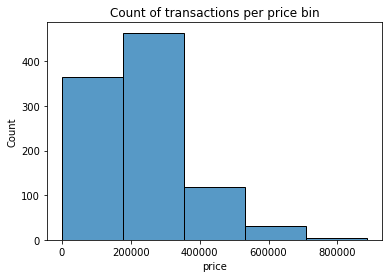

In [67]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)
sns.histplot(housing_df['price'], bins=bins)

plt.title('Count of transactions per price bin')
plt.show()

We can just add the price bin number to the "master" dataframe we've been working with.

In [68]:
bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = pd.Series(bin_array)
housing_df

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,price_bin
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
981,6932 RUSK

## Train-test splitting

Now that we have something to stratify by, let's use scikit-learn's train-test split function to split out 25% of our data for testing. The other 75% will be used to train the ML models.

In [69]:
housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'])

Verifying size of each...

In [70]:
training_df.shape

(738, 124)

In [71]:
testing_df.shape

(247, 124)

Looks good!

## Preparing the data for ML models

Most machine learning models perform better when features with floating-point or integer values are "scaled" such that their mean is 0. This helps bring all the numeric features onto the same playing field, so no small number of features dominates the calculative structure at the core of the model, whether that's a regression function, a decision tree, or otherwise.

Here, we'll use a pipeline and scikit-learn's (henceforth referred to as sklearn per it's Python `import` statement) `StandardScaler` to scale the numeric features.

The categorical features are already one-hot encoded, but we could have also created a pipeline to perform that operation with sklearn functions, then combine the pipelines into _another_ pipeline for concision.

In [72]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

# We could make a pipeline here with a one-hot encoder for the categorical columns but that's already been done

# Fit and apply the StandardScaler with the training data, then apply it to the testing data
training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

# Get the price columns
training_prices = training_df['price']
testing_prices = testing_df['price']

# Drop the columns we don't want to use in the regression model
columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

Let's take a quick look at the now preprocessed data which will be fed into the predictor pipeline.

In [73]:
testing_df.head()

,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,beds_scaled,baths_scaled,sq__ft_scaled,latitude_scaled,longitude_scaled
447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.078169,-0.875957,-0.306830,-0.596551,-0.882370
648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.385715,2.526446,1.398755,-1.004439,-0.342681
63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.078169,-0.875957,0.199910,-2.491349,0.371722
765,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.078169,0.258177,0.654893,-1.473562,-0.665312
601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-2.229377,-2.010092,-1.580302,1.925950,0.463382


## Predicting the prices

We'll use an `SGDRegressor` class from sklearn to predict the prices for our testing dataset. But first, we need to _train_ it with the training dataset.

In [74]:
reg = SGDRegressor()
reg.fit(training_df, training_prices)

SGDRegressor()

Easy, right? Now comes the fun part: predicting the prices. We'll construct a new dataframe with the actual prices and the predicted prices spit out by the trained SGDRegressor.

In [75]:
testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
447,233641,137675.660621
648,159900,196067.828662
63,188741,234375.884122
765,285000,311692.763171
601,4897,74401.182420


These seem to be _somewhat_ in the ballpark (don't yell at me if there are outliers in the `head`, we'll take care of them later), so let's find the mean error.

In [76]:
actual_prices = testing_prices_actual_predict['actual_price']
predicted_prices = testing_prices_actual_predict['predicted_price']
sqrt(mean_squared_error(actual_prices, predicted_prices))

99210.50097981495

This means that the average prediction is off by about $100k. Let's visualize the results. On the X-axis is the actual price of the transactions, with the predictions on the Y-axis. I've gone ahead and added a `Y=X` line too in red for reference. The closer our datapoints are to that, the more accurate the model is.

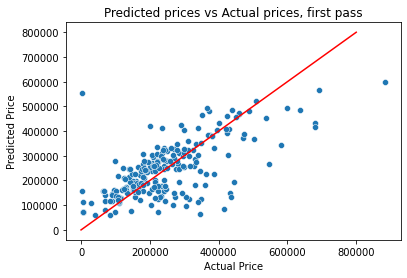

In [77]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 8e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, first pass")
plt.show()

An alternative way to represent this is to plot the error as a function of the price predictions. I've also added a `Y=0` line in red for reference. Similarly, the closer the data points are to it, the more accurate the model is. Since the error used here is _signed_, transactions below the line had their price _over_ predicted, while the ones above it had their price _under_ predicted.

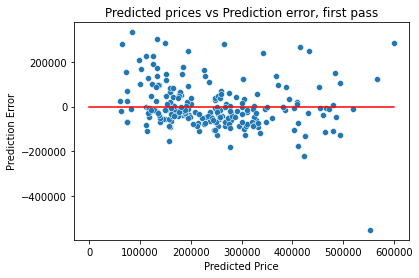

In [78]:
testing_prices_actual_predict['error'] = testing_prices_actual_predict['actual_price'] - testing_prices_actual_predict['predicted_price']

prediction_errors = testing_prices_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, first pass")
plt.show()

## Removing Outliers

Let's remove the outliers that meet one or more of these conditions:
* Square-footage of 0
* Property type of "uknown" [sic]
* Properties with very high or low prices

Removing the outliers is a good and cheap way to improve the accuracy of the model.